# A simple CNN model to classify jpeg thumbnails as cloudy (0) or cloudfree (1)

In [12]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from CNN import CNN
from DataGenerator import DataGenerator

seed = 42

# prepare train, val, test datasets

In [2]:
dataset = pd.read_csv("../data/sentinel2_clouds/labels.csv")
# reconstruct full path to jpegs files
dataset["filename"] = dataset.apply(lambda x: os.path.join("../data/sentinel2_clouds", x["parcel_id"], x["filename"]+".jpeg"), axis=1)
# smallest number of samples for a given label (0 or 1) and a given parcel
min_samples = dataset.groupby(["parcel_id", "label"]).agg("count").min()[0]

# randomly sample min_samples from each group
subset = dataset.groupby(["parcel_id", "label"]).sample(n=min_samples, replace=False, random_state=seed)
parcel_ids = subset["parcel_id"].unique()
n_parcels = len(parcel_ids)
print(f"Number of parcels {n_parcels}")

Number of parcels 39


In [3]:
train_parcels, test_parcels = train_test_split(parcel_ids, test_size=0.3, random_state=seed, shuffle=True)
test_parcels, val_parcels = train_test_split(test_parcels, test_size=0.3, random_state=seed, shuffle=True)

train_dataset = pd.concat([dataset[dataset["parcel_id"]==parcel_id] for parcel_id in train_parcels])
test_dataset = pd.concat([dataset[dataset["parcel_id"]==parcel_id] for parcel_id in test_parcels])
val_dataset = pd.concat([dataset[dataset["parcel_id"]==parcel_id] for parcel_id in val_parcels])

**make TF data generators**

In [4]:
DG = DataGenerator()

train_ds = DG.get_dataset(
    filenames=train_dataset["filename"].to_numpy(), 
    labels=train_dataset["label"].to_numpy(), 
    batch_size=5, 
    n_prefetch=1,
    training=True
)

val_ds = DG.get_dataset(
    filenames=val_dataset["filename"].to_numpy(), 
    labels=val_dataset["label"].to_numpy())

test_ds = DG.get_dataset(
    filenames=test_dataset["filename"].to_numpy(), 
    labels=test_dataset["label"].to_numpy())

2021-11-07 21:13:36.172038: W tensorflow/stream_executor/platform/default/dso_loader.cc:65] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-11-07 21:13:36.172079: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-07 21:13:36.172103: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost): /proc/driver/nvidia/version does not exist


# make CNN model

In [14]:
cnn = CNN()
opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
cnn.model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("./model_weights/model.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

cnn.model.fit(train_ds, validation_data=val_ds , epochs=50, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
1840/1840 [==============================] - 24s 13ms/step - loss: 0.2916 - accuracy: 0.8871 - val_loss: 0.2742 - val_accuracy: 0.9038
Epoch 2/50
1840/1840 [==============================] - 24s 13ms/step - loss: 0.2376 - accuracy: 0.9170 - val_loss: 0.2296 - val_accuracy: 0.9143
Epoch 3/50
1840/1840 [==============================] - 22s 12ms/step - loss: 0.2351 - accuracy: 0.9178 - val_loss: 0.2451 - val_accuracy: 0.9064
Epoch 4/50
1840/1840 [==============================] - 20s 11ms/step - loss: 0.2223 - accuracy: 0.9227 - val_loss: 0.2450 - val_accuracy: 0.9169
Epoch 5/50
1840/1840 [==============================] - 20s 11ms/step - loss: 0.2231 - accuracy: 0.9230 - val_loss: 0.2501 - val_accuracy: 0.9169
Epoch 6/50
1840/1840 [==============================] - 20s 11ms/step - loss: 0.2292 - accuracy: 0.9204 - val_loss: 0.2169 - val_accuracy: 0.9160
Epoch 7/50
1840/1840 [==============================] - 19s 11ms/step - loss: 0.2187 - accuracy: 0.9238 - val_loss: 0.1958 -

# reload model from saved weights

In [5]:
cnn_t = CNN()
opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
cnn_t.model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
cnn_t.model.load_weights("./model_weights/model.h5")
# evaluate on test dataset
cnn_t.model.evaluate(test_ds)

2021-11-07 21:13:41.787065: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


697/697 [==============================] - 3s 3ms/step - loss: 0.1647 - accuracy: 0.9417


[0.1647462546825409, 0.9417336583137512]

In [7]:
p_false = []
for batch in test_ds:
    pred = cnn_t.model.predict(batch[0]).flatten()
    pred_labels = pred>=0.5
    true_labels = batch[1].numpy()
    select_false = ((pred_labels==1) & (true_labels==0)) |\
    ((pred_labels==0) & (true_labels==1))
    if any(select_false):
        p_false.extend(pred[select_false].tolist())

2021-11-07 21:04:06.729271: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


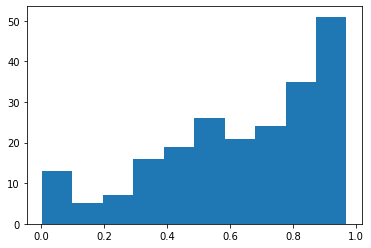

In [11]:
# output proba for false classifications are not necessarily close to 0.5
fig, ax = plt.subplots()
ax.hist(p_false)
plt.show()

# inference

In [6]:
def get_files(path, extensions=(".tif", ".tiff")):
    results = []
    for r, d, files in os.walk(path):
        for f in files:
            if f.endswith(extensions):
                results.append(os.path.join(r, f))
    return results

In [7]:
jpegs = get_files("../data/sentinel2_clouds", extensions=("jpeg"))

In [8]:
# keep only unlabeled jpegs
jpegs = [jpeg for jpeg in jpegs if os.path.dirname(jpeg).split("/")[-1] not in parcel_ids]
len(jpegs)

46659

In [9]:
DG = DataGenerator()

inference_ds = DG.get_dataset_inference(
    filenames=jpegs, 
    batch_size=5, 
    n_prefetch=1
)

In [11]:
pred = cnn_t.model.predict(inference_ds).flatten()

In [14]:
# copy jpegs into cloud and nocloud folders based on prediction
nocloud_folder = "../data/sentinel2_clouds/inference/nocloud"
cloud_folder = "../data/sentinel2_clouds/inference/cloud"
os.makedirs(nocloud_folder, exist_ok=True)
os.makedirs(cloud_folder, exist_ok=True)
for p, jpeg in zip(pred, jpegs):
    if p>=0.5: # no cloud
        shutil.copyfile(jpeg, os.path.join(nocloud_folder, os.path.basename(jpeg)))
    else:
        shutil.copyfile(jpeg, os.path.join(cloud_folder, os.path.basename(jpeg)))